<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/logo_mt_0_0.png" WIDTH=280 HEIGHT=280>
</div>
<div id="subject">
<CENTER>
</br>


<font size="5"></br> UE Introduction au Machine Learning: Réseaux de neurones </font></br></div>
</CENTER>
<CENTER>
<font size="3"></br>Fall 2020</font></br></div>
</CENTER>
<CENTER>
<span style="color:blue">lucas.drumetz@imt-atlantique.fr</span>
</CENTER>

The goal of this lab is to get a first practice of neural networks. You will recode a simple nonlinear neural network with one hidden layer from scratch, meaning that you will have to handle all the necessary steps:
definition of the model, computation of the output of the model (forward pass), computation of the gradient of the network with respect to the all model parameters, and finally optimization by gradient descent.

This will give you a good idea of the basic building blocks needed for neural nets. Note that all the deep learning packages for Python (e.g. Pytorch, Keras, Tensorflow) do most of this work for you, letting you focus on the definition of your model and cost function.

# Classification problem

We first define a binary classification problem in 2D with nonlinearly separable classes. For this problem, simple nonparameteric methods would work just fine (e.g. KNN) but the parametric methods seen so far failed to correctly classify this dataset. We will consider two dataset: a simple one (two moons) and a slightly more challenging ones (spirals).

In [1]:
# imports and definition of the two functions to generate the data

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_moons

from matplotlib.colors import ListedColormap

def twospirals(n_points, noise=.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 720 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
        np.hstack((np.zeros(n_points),np.ones(n_points))))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])




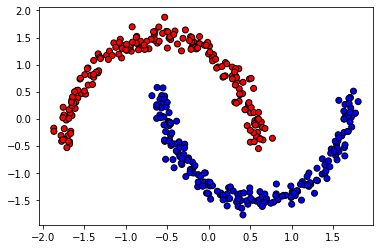

In [2]:
# data generation, normalization and plotting

noise = 0.5    
n_samples = 500

#(X,Y) = twospirals(n_points=n_samples, noise=noise)
X,Y = make_moons(n_samples=n_samples, shuffle=True, noise=noise/10, random_state=None)

X = StandardScaler().fit_transform(X) #zero mean and unit variance

Y = Y.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

fig = plt.figure()
plt.scatter(x_train[:,0],x_train[:,1],c=y_train[:,0],cmap=cm_bright,edgecolors='k')
plt.show()


First, given the nature of the problem, set the appropriate values for the dimensions of the inputs and outputs of your model. Set a value for the number of neurons in the hidden layer.

In [3]:
# Initialize variables depending on the problem to tackle

input_size = X.shape[1]
output_size = Y.shape[1]

nb_neurons_hidden_layer = 25 # arbitrary, can be changed


We will need to define some auxiliary functions: First the activation functions and the cost function we will use. We will use sigmoid activation functions, both for the hidden and output layers. For the output layer, this comes from the fact that we have a binary classification problem. For the hidden layer, this is our choice.

Define the sigmoid function and a "vectorized" version applying it to all the elements of a vector (this one is given). Also define the loss function we will use, the binary cross entropy function. It takes as argument the true labels and the output of your model. Hint: you can implement it easily with an "if" statement on the value of the true label.

\begin{equation*}
L(\mathbf{y},\mathbf{t}) = \sum_{n=1}^{N} l(y_{n},t_{n}) = -\sum_{n=1}^{N}  \left( t_{n} \textrm{ln}(y_{n}) + (1-t_{n}) \textrm{ln}(1-y_{n}) \right)
\end{equation*}

where $\mathbf{y}$ is the output of your model (concatenated for each sample) and $\mathbf{t}$ is the set of all true target variables, for each sample.

In [4]:
# initialize all variables for forward pass

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_vectorized(x):
    return np.array(list(map(sigmoid, x)))

# The idea is to see in the above expression which term cancels out when t_n = {0, 1}
def CrossEntropy(yHat, y):
    if y == 1:
        return -np.log(yHat)
    else:
        return -np.log(1 - yHat)

Code the function implementing the "forward pass", i.e. computing the output of your network, given one input sample $x = \mathbf{x}_{n}$ for some $n$, and all its parameters (weight matrices and biases for all layers). It should return all the intermediary variables, i.e. the outputs of each layer, after ($a_i$, with $i$ the layer index) and before ($z_i$) applying the activation function. We will need those to compute the gradient of the function w.r.t. all the parameters. How many trainable parameters does your network have?

In [5]:
def forward(x,W1,b1,W2,b2):
    z1 = np.dot(W1, x) + b1
    a1 = sigmoid_vectorized(z1)
    
    z2 = np.dot(W2, a1) + b2
    a2 = sigmoid_vectorized(z2)
    
    return(z1,a1,z2,a2)


Now, implement the "backward pass", i.e. implement a function that takes as inputs all the parameters of your model, and also the variables computed during the forward pass, and outputs the gradients of your loss function $l$ w.r.t. all these parameters.

You will use the chain rule to compute the derivative of the loss function w.r.t. all the intermediary variables, and implement it "by hand". Automatic differentiation does this in an automated way by keeping track of all the dependencies between variables using a tree structure (you can draw one yourself for this example to see the dependencies!).

Begin by calculating the derivative of the "output" variable s w.r.t the output of the network $y_{n} = a_2$:
\begin{equation*}
\frac{\partial s}{\partial a_2} = \frac{\partial s}{\partial l} \frac{\partial l}{\partial a_2}
\end{equation*}
$\frac{\partial s}{\partial l}$ is the seed (known), so you only need to compute by hand $\frac{\partial l}{\partial a_2}$.
Then you can compute the derivatives of $s$ w.r.t. the variables on which $a_2$ depends directly, here only $z_2$:
\begin{equation*}
\frac{\partial s}{\partial z_2} = \frac{\partial s}{\partial a_2} \frac{\partial a_2}{\partial z_2}
\end{equation*}
You can easily show that the sigmoid function has a simple derivative: 
\begin{equation*}
\sigma'(z_2) = \sigma(z_2)(1-\sigma(z_2))
\end{equation*}
Computing this allows you to move on to compute $\frac{\partial s}{\partial W_2}$ and $\frac{\partial s}{\partial b_2}$, and so on...

In [6]:
ds = 1 # seed for backward differentiation (initial value of ds/dl, in practice set to 1 if s=l at the output)

# if a is a variable, we denote by da the value of ds/da for the current value of the parameters,
# inputs and intermediary variables.
# the operations corresponding to differentiations can be found as comments

def backward(W1,b1,W2,b2,y,ds,z1,a1,z2,a2,x):
    #dl/da2 = [y/a2 - (1-y)/(1-a2)] = -[y*(1-a2)/(a2*(1-a2)) - (1-y)*a2/(a2*(1-a2))] = (a2 - y)/(a2*(1-a2))
    da2 = ds*(a2-y)/(a2*(1-a2)) 
    dz2 = da2*a2*(1-a2)   #da2/dz2 = sigmoid'(z2) = a2*(1-a2)
    dw2 = dz2*a1 # dz2/dw2 = a1
    db2 = dz2 # dz2/db2 = 1
    da1 = np.dot(dz2,W2) # dz2/da1 = W2
    dz1 = da1*a1*(1-a1) # da1/dz1 = sigmoid'(z1) = a1*(1-a1)
    dw1 = np.zeros((nb_neurons_hidden_layer,input_size))
    for k in range(nb_neurons_hidden_layer):
        dw1[k,:] = dz1[k]*x # dz1/dw1 = x
    db1 = dz1 # dz1/db1 = 1
    
    return dw2,db2,dw1,db1

Now that we have our model, our loss function and know how to compute the gradients w.r.t. all the trainable parameters, we can finally train our model by gradient descent. Implement a function taking as input all the training samples and labels, a learning rate (gradient descent step size), a number of epochs (iterations of the gradient descent), and the seed of the derivative calculation.

This function should return the final values of the parameters, and the value of the total loss function computed over all training samples, at each epoch (so we can check whether the function is decreasing).

In [7]:
def network_training(X,Y,lr,epochs,ds):
    
    # random initialization of the parameters

    W1 = np.random.randn(nb_neurons_hidden_layer,input_size)
    b1 = np.random.randn(nb_neurons_hidden_layer)

    W2 = np.random.randn(output_size,nb_neurons_hidden_layer)
    b2 = np.random.randn(output_size)

    loss = np.zeros(epochs) # total loss function value
    
    # loop over epochs
    
    for k in range(epochs):
    
        # initialize gradients and loss
    
        N = np.shape(X)[0]
        loss_ = 0
        dw2 =  np.ones((output_size,nb_neurons_hidden_layer))
        db2 =  np.ones(output_size)
        dw1 =  np.ones((nb_neurons_hidden_layer,input_size))
        db1 =  np.ones(nb_neurons_hidden_layer)

        # inner loop over all samples
        
        for i in range(N):
            # _p after the variable names means "present"
            # compute the output of the model for the current input
            
            z1_p, a1_p, z2_p, a2_p = forward(X[i,:], W1, b1, W2, b2)
            
            # compute the loss function value
            
            loss_p = CrossEntropy(a2_p, Y[i])          
            
            # add the current loss to the total loss
            
            loss_ += loss_p
            
            # compute the gradients
            
            dw2_p, db2_p, dw1_p, db1_p = backward(W1, b1, W2, b2, Y[i], ds, z1_p, a1_p, z2_p, a2_p, X[i,:])
            
            # add the current gradient values to the total gradient values
            
            dw1 = dw1 + dw1_p
            db1 = db1 + db1_p
            dw2 = dw2 + dw2_p
            db2 = db2 + db2_p
            
        # print loss every 50 epochs    
        
        loss[k] = loss_
        if np.mod(k, 50) == 0: 
            print(loss_)
       
    
        # perform gradient descent with the same step size for all parameters
        
        W1 = W1 - lr*dw1
        b1 = b1 - lr*db1
        W2 = W2 - lr*dw2
        b2 = b2 - lr*db2
        
    return(W2,b2,W1,b1,loss)
 

Train your network by choosing an appropriate learning rate and number of epochs. Plot the value of the loss function across training epochs.

In [8]:
epochs = 1000
lr = 2*10**(-3)

W2, b2, W1, b1, loss = network_training(x_train, y_train, lr, epochs, ds) 

[748.26535115]
[107.47091879]
[100.00412706]
[90.35703071]
[79.29597559]
[68.3441057]
[58.52717608]
[50.2079724]
[43.36016896]
[37.78493243]
[33.24407746]
[29.52402285]
[26.45213029]
[23.89409345]
[21.74664104]
[19.93004214]
[18.38179789]
[17.05202387]
[15.90046436]
[14.89469679]


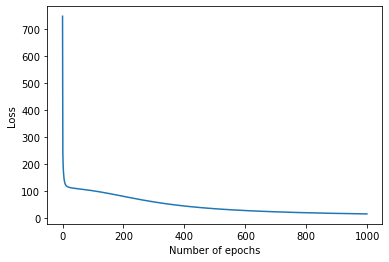

In [9]:
# training loss
plt.figure
plt.plot(np.arange(epochs), loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.show()

Now it's time to test the network, i.e. make predictions on the test set and check the classification accuracy. 
For this, you just have to use the forward function an all test samples, using the values of the parameters you obtained from the training phase.

Since the output of the network is a real number between 0 and 1, do not forget to threshold it to make the binary classification decision! Then you can compute the classification accuracy on the test set.

In [10]:
# test

N_test = np.shape(x_test)[0]
labels_pred = np.zeros(N_test)
y_pred = np.zeros(N_test)

# compute network predictions for all test samples

for i in range(N_test):
    z1, a1, z2, y_pred[i] = forward(x_test[i,:], W1, b1, W2, b2)

# Make binary decision
    
labels_pred[y_pred > 0.5] = 1

# classification accuracy

print(np.sum(labels_pred == y_test.T)/N_test)

1.0


Finally, you can visualize the nonlinear decision boundaries of your trained model together with the dataset

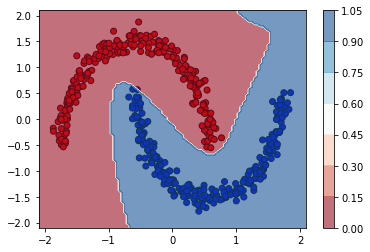

In [11]:
grid_size = 100

x = np.linspace(-2.1,2.1,grid_size)
y = np.linspace(-2.1,2.1,grid_size)

def plot_decision_boundary(x,y,X,labels):
    # to be completed
    # x and y are the vectors giving the extent of the 2D grid
    # X is the data, labels the true labels to plot the data on top of the boundaries
    
    # define grid of points
    
    [xx,yy] = np.meshgrid(x,y)
    Z = np.zeros(grid_size*grid_size)
    
    # compute binary predictions for all the points of the grid
    
    for i in range(np.shape(Z)[0]):
        dummy0, dummy1, dummy3,Z[i] = forward(np.c_[xx.ravel(), yy.ravel()][i],W1,b1,W2,b2)
    
    Z[Z>0.5] = 1
    Z[Z<=0.5] = 0
    
    Z = Z.reshape(grid_size,grid_size)
    
    # scatterplot of the data and contour lines of the decision function
    
    plt.scatter(X[:,0],X[:,1], c = labels,cmap=cm_bright,edgecolors='k')
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha = 0.6)
    
# use the function to show all the info
    
plot_decision_boundary(x,y,X,Y[:,0]) 
plt.colorbar()

Try to change the dataset for the spiral dataset (in the second cell), and check whether or not your network works on that example. **Answer:** it does not. 

# Regression problem (optional)

If you have time, try to adapt your network for a regression problem, with a 2-dimensional input and a real value to predict. What are the changes that you need to make to the network architecture and cost function?

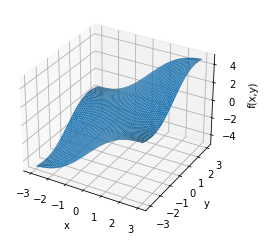

In [12]:
from mpl_toolkits.mplot3d import Axes3D

def f(x,y): 
#     return np.sin(y) + np.sin(2*x) 
     return 0.1* (10*x+5*y+ np.sin(y) *x**2 + np.sin(x)* y**2 )

step = 0.01
x = np.arange(-3,3,step)
y = np.arange(-3,3,step)

[X,Y] = np.meshgrid(x,y)

Z = f(X,Y)
# Z = StandardScaler().fit_transform(Z) #zero mean and unit variance

fig = plt.figure(1)
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y,Z)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)');

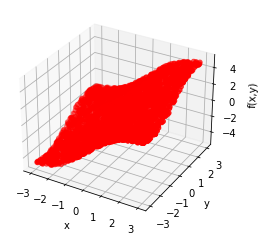

In [13]:
# sample a certain number of points from this function to form the training set

nb_samples = 3000
#nb_samples = 10000

x = np.random.uniform(-3,3,nb_samples)
y = np.random.uniform(-3,3,nb_samples)

xy = np.stack((x,y),1)

xy = StandardScaler().fit_transform(xy) #zero mean and unit variance


z = f(x,y)
# z = StandardScaler().fit_transform(z.reshape(-1,1)) #zero mean and unit variance

fig = plt.figure(1)
ax = fig.gca(projection='3d')
ax.scatter3D(x,y,z,c ='r')
#ax.plot_surface(X,Y,Z)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)');



In [14]:
nb_neurons_hidden_layer = 15

In [15]:
def forward_regression(x,W1,b1,W2,b2):
    z1 = np.dot(W1,x) + b1
    a1 = sigmoid_vectorized(z1)
    
    z2 = np.dot(W2,a1) + b2
    # same as before but as it is a regression problem we do not apply the sigmoid function int he end
    
    return(z1,a1,z2)

In [16]:
def backward_regression(W1,b1,W2,b2,y,ds,z1,a1,z2,x):
    # Only the following two lines change with respect to the previous case (and a2 is not an argument anymore)
    #l = 1/(2m)*(y_hat - y)^2 with y_hat = z2
    dz2 = ds*(z2 - y) # dl/dz2 = z2 - y
    dw2 = dz2*a1 # dz2/dw2 = a1
    db2 = dz2 # dz2/db2 = 1
    da1 = np.dot(dz2,W2) # dz2/da1 = W2
    dz1 = da1*a1*(1-a1) # da1/dz1 = sigmoid'(z1) = a1*(1-a1)
    dw1 = np.zeros((nb_neurons_hidden_layer,input_size))
    for k in range(nb_neurons_hidden_layer):
        dw1[k,:] = dz1[k]*x # dz1/dw1 = x
    db1 = dz1 # dz1/db1 = 1
    
    return dw2,db2,dw1,db1

In [17]:
# In this case I need to change forward for forward_regression and backward for backward_regression
# Also there are changes in the loss
def network_training_regression(X,Y,lr,epochs,ds):
    
    # random initialization of the parameters

    W1 = np.random.randn(nb_neurons_hidden_layer,input_size)
    b1 = np.random.randn(nb_neurons_hidden_layer)

    W2 = np.random.randn(output_size,nb_neurons_hidden_layer)
    b2 = np.random.randn(output_size)

    loss = np.zeros(epochs) # total loss function value
    
    # loop over epochs
    
    for k in range(epochs):
    
        # initialize gradients and loss
    
        N = np.shape(X)[0]
        loss_ = 0
        dw2 =  np.ones((output_size,nb_neurons_hidden_layer))
        db2 =  np.ones(output_size)
        dw1 =  np.ones((nb_neurons_hidden_layer,input_size))
        db1 =  np.ones(nb_neurons_hidden_layer)

        # inner loop over all samples
        
        for i in range(N):
            # _p after the variable names means "present"
            # compute the output of the model for the current input
            
            z1_p, a1_p, z2_p = forward_regression(X[i,:], W1, b1, W2, b2)
            
            # compute the loss function value
            # this changes as the loss function is different
            
            loss_p = (z2_p - Y[i])**2         
            
            # add the current loss to the total loss
            
            loss_ += loss_p
            
            # compute the gradients
            
            dw2_p, db2_p, dw1_p, db1_p = backward_regression(W1, b1, W2, b2, Y[i], ds, z1_p, a1_p, z2_p, X[i,:])
            
            # add the current gradient values to the total gradient values
            
            dw1 = dw1 + dw1_p
            db1 = db1 + db1_p
            dw2 = dw2 + dw2_p
            db2 = db2 + db2_p
            
        # print loss every 50 epochs    
        
        loss[k] = loss_
        if np.mod(k, 50) == 0: 
            print(loss_)
       
    
        # perform gradient descent with the same step size for all parameters
        
        W1 = W1 - lr*dw1
        b1 = b1 - lr*db1
        W2 = W2 - lr*dw2
        b2 = b2 - lr*db2
        
    return(W2,b2,W1,b1,loss)
 

In [18]:
epochs = 2000
lr = 2*10**(-4)

W2, b2, W1, b1, loss = network_training_regression(xy, z, lr, epochs, ds) 

[17952.10695223]
[3562.09979145]
[2576.23874267]
[1688.75332447]
[1188.94697961]
[720.11679934]
[451.74720366]
[340.37218906]
[293.8878593]
[269.58483215]
[251.75110016]
[235.03042506]
[218.21538919]
[202.74112715]
[189.94926312]
[178.92896098]
[168.38376056]
[157.59608015]
[146.38859987]
[135.10288592]
[124.49950796]
[115.42585748]
[108.35872686]
[103.20437233]
[99.5098321]
[96.78338537]
[94.65794029]
[92.90461618]
[91.39229011]
[90.04758015]
[88.82852194]
[87.70975536]
[86.67475693]
[85.71187818]
[84.81232468]
[83.96910099]
[83.17643472]
[82.42944191]
[81.72391766]
[81.05619531]


In [19]:
np.arange(epochs)

array([   0,    1,    2, ..., 1997, 1998, 1999])

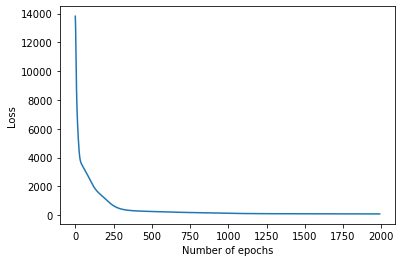

In [20]:
# At the beginning it 'explodes'
plt.figure()
plt.plot(np.arange(epochs-10),loss[10:])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.show()

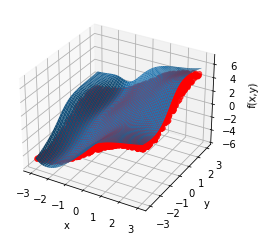

In [21]:
step = 0.01
x_grid = np.arange(-3,3,step)
y_grid = np.arange(-3,3,step)

[X,Y] = np.meshgrid(x_grid,y_grid)

Z_net = np.zeros(np.shape(Z))

for i in range(np.shape(X)[0]):
    for j in range(np.shape(Y)[0]):
        dummy0, dummy1, Z_net[j,i] = forward_regression(np.stack((X[0,i],Y[j,0]),0),W1,b1,W2,b2)


fig = plt.figure(1)
ax = fig.gca(projection='3d')
ax.scatter3D(x,y,z,c ='r')
ax.plot_surface(X,Y,Z_net);

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)');